## Overview

1. Stacking
2. Feature importance
3. XGBoost Stacking

In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold;



# Feature Exploration, Engineering and Cleaning

In [2]:
train = pd.read_csv('train_ensemble.csv')
test = pd.read_csv('test_ensemble.csv')

### Store passenger ID for easy access


PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
full_data = [train,test]

# Some features of my own that I have added in
# Gives the length of the name
train["Name_length"] = train['Name'].apply(len)
test["Name_length"] = test["Name"].apply(len)

## Feature that tells whether a passenger had a cabin on boat
### nan type = float,but string (if has cabin) return false

train["Has_Cabin"] = train["Cabin"].apply(lambda x: 0 if type(x)== float else 1)
test["Has_Cabin"] = test["Cabin"].apply(lambda x:0 if type(x) == float else 1)

## Feature engineering
### Create new feature FamilySize
for dataset in full_data:
    dataset["FamilySize"] = dataset["SibSp"]+dataset["Parch"]+1
    
## Create new feature IsAlone from FamilySize

for dataset in full_data:
    dataset["IsAlone"] = 0
    dataset.loc[dataset["FamilySize"] == 1, 'IsAlone'] = 1
    
# Remove all nulls in Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset["Fare"] = dataset['Fare'].fillna(train['Fare'].median())
### cut to 4 quantile group    
train['CategoricalFare'] = pd.qcut(train['Fare'],4)

## Create new feature CategoricalAge

for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg-age_std,age_avg+age_std,size = age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

train['CategoricalAge'] = pd.cut(train['Age'],5)

### Define function to extract titles from passenger names 
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.',name)
    
    ## If title exists, extract and return it
    if title_search:
        return title_search.group(1)
    
    return ""

## Create a new feature Title, containing the titles of passenger names
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col'
                                                 ,'Don', 'Dr', 'Major', 'Rev', 'Sir'
                                                 , 'Jonkheer', 'Dona'], 'Rare')
    
    dataset['Title'] = dataset['Title'].replace('Mlle','Miss')
    dataset['Title'] = dataset['Title'].replace('Ms','Miss')
    dataset['Title'] = dataset['Title'].replace('Mme','Mrs')
    
for dataset in full_data:
    ## Mapping Sex
    dataset['Sex'] = dataset['Sex'].map({'female':0,'male':1}).astype(int)
    
    ## Mapping titles
    
    title_mapping = {"Mr":1,"Miss":2,"Mrs":3,"Master":4,"Rare":5}
    
    dataset["Title"] = dataset['Title'].map(title_mapping)
    ## Mapping embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    ## Mapping Fare
    dataset.loc[dataset['Fare'] <=7.91, 'Fare'] = 0
    
    dataset.loc[(dataset['Fare']>7.91) & (dataset['Fare']<=14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare']>14.454) & (dataset['Fare']<=31),'Fare']=2
    dataset.loc[(dataset['Fare']>31),'Fare'] = 3
    
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    ## Mapping Age
    
    dataset.loc[dataset['Age']<=16,'Age']= 0
    dataset.loc[(dataset['Age']>16) & (dataset['Age']<=32), "Age"] = 1
    dataset.loc[(dataset['Age']>32) & (dataset['Age']<=48),"Age"] = 2
    dataset.loc[(dataset['Age']>48) & (dataset['Age']<=64), "Age"] = 3
    dataset.loc[dataset['Age']>64,'Age'] = 4;
    
    
    
    
    
    

### Feature selection

In [4]:

drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

### Visualization

In [5]:
train.head()
train.describe()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,1.352413,0.381594,1.505051,0.361392,26.965208,0.228956,1.904602,0.602694,1.728395
std,0.486592,0.836071,0.477989,0.840910,0.806057,1.118149,0.635675,9.281607,0.420397,1.613459,0.489615,1.030039
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,1.000000,0.000000,1.000000
25%,0.000000,2.000000,0.000000,1.000000,0.000000,0.500000,0.000000,20.000000,0.000000,1.000000,0.000000,1.000000
50%,0.000000,3.000000,1.000000,1.000000,0.000000,2.000000,0.000000,25.000000,0.000000,1.000000,1.000000,1.000000
75%,1.000000,3.000000,1.000000,2.000000,0.000000,2.000000,1.000000,30.000000,0.000000,2.000000,1.000000,2.000000
max,1.000000,3.000000,1.000000,4.000000,6.000000,3.000000,2.000000,82.000000,1.000000,11.000000,1.000000,5.000000


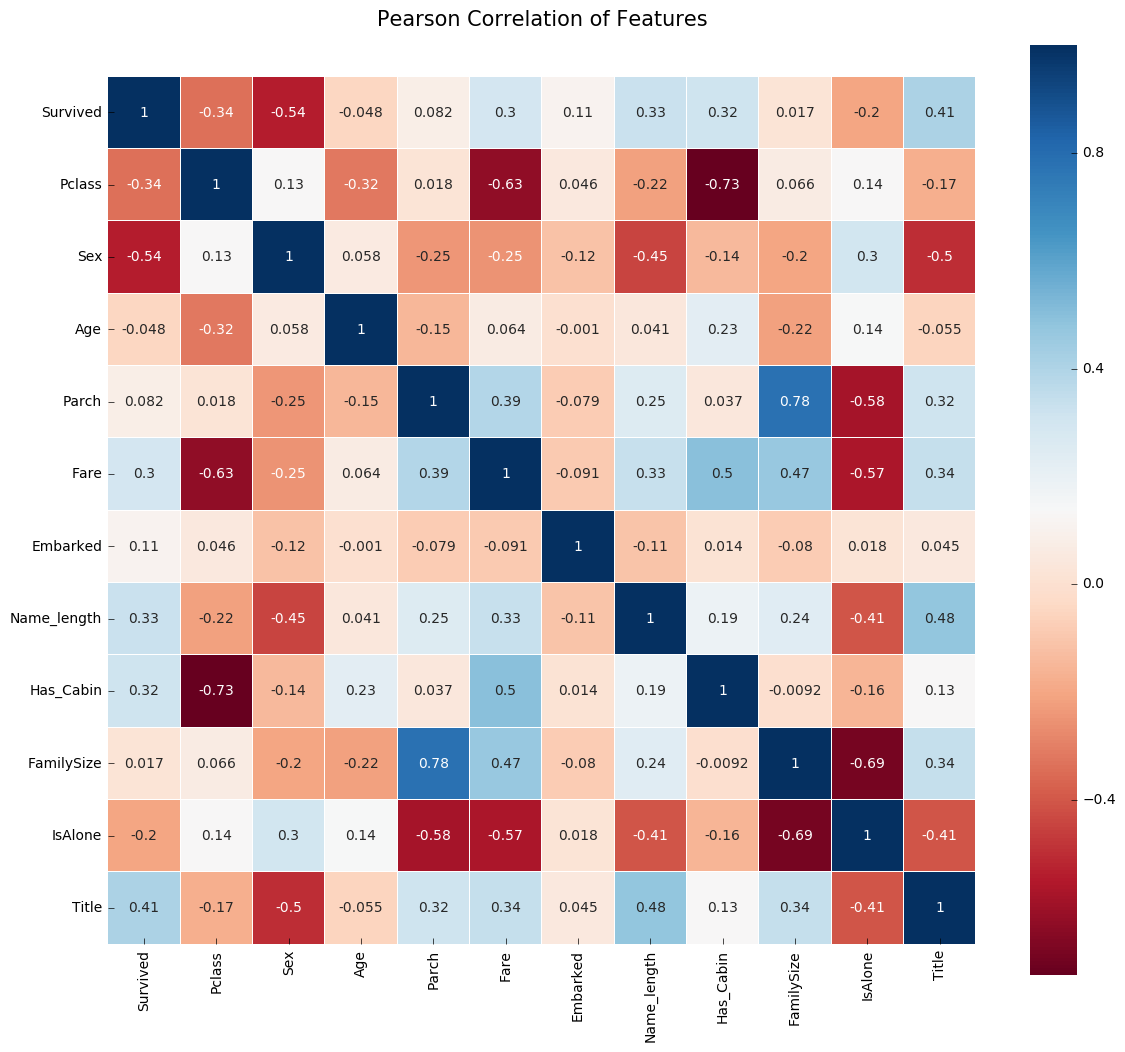

In [6]:
## Pearson correlation heat map
import seaborn as sns
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

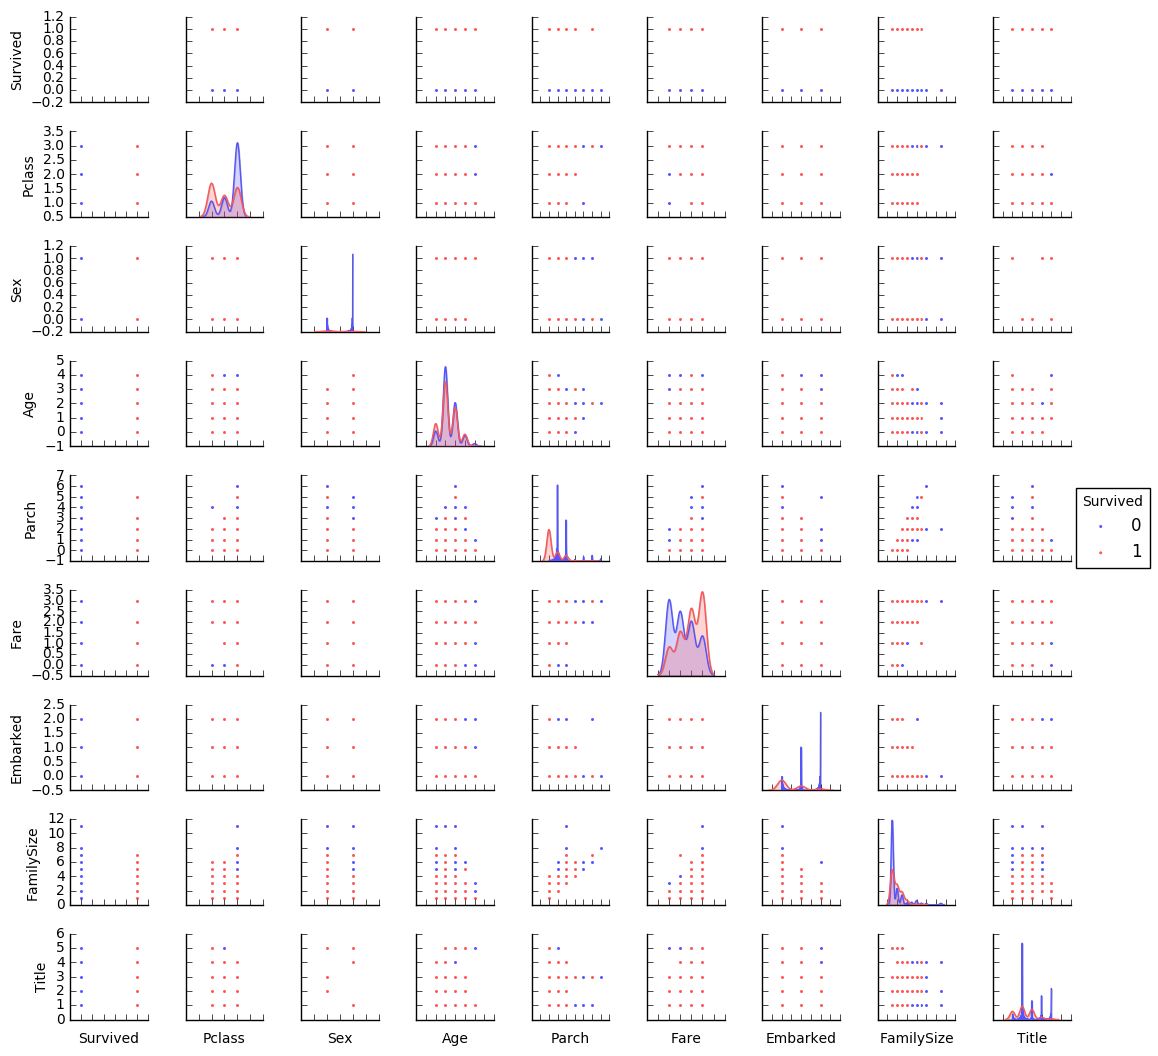

In [7]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

### Sklearn helper function for later stacking

In [9]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 
NFOLDS = 5
kf = KFold(ntrain,n_folds = NFOLDS, random_state = SEED)

class SklearnHelper(object):
    def __init__(self,clf,seed = 0,params = None):
        params['random_state'] = seed
        self.clf = clf(**params)
        
    def train(self,x_train,y_train):
        self.clf.fit(x_train,y_train)
        
    def predict(self,x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
        
    ## class to extend CGBoost classifier
        

## Out-of-Fold Predictions

- stacking uses predictions of base classifiers as input for training to a second-level model



In [10]:
def get_oof(clf,x_train,y_train,x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS,ntest))
    
    for i,(train_index,test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr,y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i,:] = clf.predict(x_test)
        
        oof_test[:] = oof_test_skf.mean(axis = 0)
        return oof_train.reshape(-1,1), oof_test.reshape(-1,1)
            

## Generating our Base First-Level Models

In [11]:
rf_params = {
    'n_jobs':-1,
    'n_estimators':500,
    'warm_start': True,
    'max_depth':6,
    'min_samples_leaf':2,
    'max_features':'sqrt',
    'verbose':0
}

et_params = {
    'n_jobs':-1,
    'n_estimators':500,
    'max_depth':8,
    'min_samples_leaf':2,
    'verbose':0
}


ada_params = {
    'n_estimators':500,
    'learning_rate':0.75
}


gb_params = {
    'n_estimators':500,
    'max_depth':5,
    'min_samples_leaf':2,
    'verbose':0
}

svc_params = {
    'kernel':'linear',
    'C':0.025
}

In [12]:
rf = SklearnHelper(clf = RandomForestClassifier,seed = SEED,params = rf_params)
et = SklearnHelper(clf = ExtraTreesClassifier,seed = SEED,params = et_params)
ada = SklearnHelper(clf = AdaBoostClassifier,seed = SEED,params = ada_params)
gb = SklearnHelper(clf = GradientBoostingClassifier,seed = SEED,params = gb_params)
svc = SklearnHelper(clf = SVC,seed = SEED,params = svc_params)


In [13]:
## Create numpy arrays of train and test to feed into our model

y_train = train['Survived'].ravel()
train = train.drop(['Survived'],axis = 1)
x_train = train.values
x_test = test.values

### First level classifiers

In [14]:

et_oof_train, et_oof_test = get_oof(et,x_train,y_train,x_test)
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train,x_test)
ada_oof_train, ada_oof_test = get_oof(ada,x_train,y_train,x_test)
gb_oof_train, gb_oof_test = get_oof(gb,x_train,y_train,x_test)
svc_oof_train, svc_oof_test = get_oof(svc,x_train,y_train,x_test)
print("Training is complete")

Training is complete


### Feature Importance

In [18]:


rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train,y_train)
ada_features = ada.feature_importances(x_train,y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[ 0.12748285  0.1966541   0.02982086  0.02188118  0.07241166  0.02416793
  0.10977153  0.06497313  0.06574399  0.01348736  0.2736054 ]
[ 0.12105845  0.37929795  0.02756513  0.0170489   0.05702746  0.0280205
  0.04570054  0.08291446  0.04329789  0.02103844  0.17703028]
[ 0.028  0.01   0.012  0.064  0.038  0.01   0.704  0.012  0.05   0.004
  0.068]
[ 0.06836829  0.03265588  0.10511655  0.03386226  0.0928728   0.05874739
  0.40318338  0.02209264  0.07626624  0.03138933  0.07544523]


In [19]:
rf_features = [0.10474135,  0.21837029,  0.04432652,  0.02249159,  0.05432591,  0.02854371
  ,0.07570305,  0.01088129 , 0.24247496,  0.13685733 , 0.06128402]
et_features = [ 0.12165657,  0.37098307  ,0.03129623 , 0.01591611 , 0.05525811 , 0.028157
  ,0.04589793 , 0.02030357 , 0.17289562 , 0.04853517,  0.08910063]
ada_features = [0.028 ,   0.008  ,      0.012   ,     0.05866667,   0.032 ,       0.008
  ,0.04666667 ,  0.     ,      0.05733333,   0.73866667,   0.01066667]
gb_features = [ 0.06796144 , 0.03889349 , 0.07237845 , 0.02628645 , 0.11194395,  0.04778854
  ,0.05965792 , 0.02774745,  0.07462718,  0.4593142 ,  0.01340093]

cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

In [20]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

### calculate the mean of all the feature importances and store it as a new column in the feature importance dataframe.

In [21]:
### Create a new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis = 1)
feature_dataframe.head(3)

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
0,0.028,0.121657,0.067961,0.104741,Pclass,0.080590
1,0.008,0.370983,0.038893,0.218370,Sex,0.159062
2,0.012,0.031296,0.072378,0.044327,Age,0.040000


In [22]:
 ## Plotly Barplot of Average Feature Importances

y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

## Second level prediction

- first level output as new features

In [23]:
base_predictions_train = pd.DataFrame({'RandomForest':rf_oof_train.ravel(),
                                       'ExtraTrees':et_oof_train.ravel(),
                                       'adaBoost':ada_oof_train.ravel(),
                                       'GradientBoost':gb_oof_train.ravel()
                                      })

base_predictions_train.head()

,ExtraTrees,GradientBoost,RandomForest,adaBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,1.0,0.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [24]:
## Correlation Heatmap of the Second Level Training set

data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')


In [25]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

## XGBoost for second level stacking classifier


In [26]:
gbm = xgb.XGBClassifier(
n_estimators = 2000,
max_depth = 4,
min_child_weight = 2,
gamma = 0.9,
subsample = 0.8,
colsample_bytree = 0.8,
objective = 'binary:logistic',
nthread = -1,
scale_pos_weight = 1).fit(x_train,y_train)

predictions = gbm.predict(x_test)

##  gamma : minimum loss reduction required to make a further partition on a leaf node of the tree. The larger, 
##  the more conservative the algorithm will be.

In [27]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission

,PassengerId,Survived
0,892,1
1,893,1
2,894,1
3,895,1
4,896,1
5,897,1
6,898,1
7,899,1
8,900,1
9,901,1
